In [58]:
import pandas as pd

## Get measurements from CSV

In [59]:
sensor_readings = pd.read_csv("D:\Master\Thesis\Code\LeakDB\LeakDB-master\measurements\measurements_1_LeakDB.csv")

sensor_readings['Timestamp'] = pd.to_datetime(sensor_readings['Timestamp'])

# Extract entity ID and type
sensor_readings['entity_id'] = sensor_readings['sensor_id'].apply(lambda x: "_".join(x.split("_")[:2]))  # e.g., Node_1 or Pipe_12
sensor_readings['measurement_type'] = sensor_readings['sensor_type']  # demand, pressure, flow
sensor_readings['entity_type'] = sensor_readings['entity_id'].apply(lambda x: x.split("_")[0])  # Node or Pipe


In [60]:
# Nodes → pressure & demand
node_df = sensor_readings[sensor_readings['entity_type'] == 'Node']
node_pivot = node_df.pivot_table(index='Timestamp', columns=['entity_id', 'measurement_type'], values='measurement')

# Pipes → flow
pipe_df = sensor_readings[sensor_readings['entity_type'] == 'Link']
pipe_pivot = pipe_df.pivot_table(index='Timestamp', columns=['entity_id', 'measurement_type'], values='measurement')

# Rewrite column names
node_pivot.columns = ['_'.join(col).strip() for col in node_pivot.columns.values]
pipe_pivot.columns = ['_'.join(col).strip() for col in pipe_pivot.columns.values]


In [61]:
pipe_pivot

,Link_1_flow,Link_10_flow,Link_11_flow,Link_12_flow,Link_13_flow,Link_14_flow,Link_15_flow,Link_16_flow,Link_17_flow,Link_18_flow,...,Link_31_flow,Link_32_flow,Link_33_flow,Link_34_flow,Link_4_flow,Link_5_flow,Link_6_flow,Link_7_flow,Link_8_flow,Link_9_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,3405.6,352.8,270.0,172.8,190.8,82.8,39.6,68.4,-212.4,-489.6,...,25.2,-36.0,54.0,198.0,1378.8,1234.8,1040.4,824.4,716.4,630.0
2017-01-01 00:30:00,2970.0,295.2,230.4,144.0,172.8,75.6,36.0,57.6,-194.4,-428.4,...,21.6,-32.4,46.8,169.2,1166.4,1054.8,900.0,723.6,615.6,543.6
2017-01-01 01:00:00,2656.8,273.6,208.8,126.0,151.2,64.8,32.4,50.4,-172.8,-388.8,...,18.0,-21.6,32.4,158.4,1054.8,957.6,802.8,640.8,561.6,493.2
2017-01-01 01:30:00,2401.2,241.2,183.6,108.0,144.0,57.6,28.8,43.2,-154.8,-363.6,...,18.0,-25.2,36.0,144.0,946.8,860.4,734.4,583.2,507.6,442.8
2017-01-01 02:00:00,2199.6,219.6,165.6,100.8,133.2,57.6,28.8,36.0,-147.6,-338.4,...,14.4,-21.6,32.4,133.2,856.8,774.0,658.8,532.8,457.2,403.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,5652.0,579.6,439.2,273.6,313.2,129.6,61.2,126.0,-352.8,-752.4,...,46.8,-64.8,90.0,342.0,2293.2,2055.6,1746.0,1353.6,1191.6,1047.6
2017-12-31 22:00:00,5360.4,554.4,421.2,273.6,298.8,129.6,68.4,126.0,-331.2,-687.6,...,39.6,-64.8,90.0,331.2,2145.6,1940.4,1641.6,1285.2,1116.0,990.0
2017-12-31 22:30:00,4935.6,518.4,399.6,255.6,270.0,111.6,54.0,115.2,-309.6,-630.0,...,32.4,-57.6,82.8,284.4,2026.8,1814.4,1526.4,1216.8,1054.8,932.4


### Separate data by feature

In [62]:
demand_cols = [col for col in node_pivot.columns if col.endswith("demand")]
pressure_cols = [col for col in node_pivot.columns if col.endswith("pressure")]

demand_df = node_pivot[demand_cols]
pressure_df = node_pivot[pressure_cols]
flow_df = pipe_pivot

## Imputation

### Split train/val, and scale

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import joblib

def split_scale(measurements, feature, cluster):

    # Step 1: Split the full data (X_seq or X_ori) into train and validation sets
    X_train_full, X_val_full = train_test_split(measurements, test_size=0.2, shuffle = False, random_state=42)

    scaler = StandardScaler()

    # Fit and transform training data
    X_train_full_scaled = X_train_full.copy()
    X_train_full_scaled = scaler.fit_transform(X_train_full)
    X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=X_train_full.columns, index=X_train_full.index)

    # Save scaler with specific name for later rescaling
    joblib.dump(scaler, f"{feature}_scaler_{cluster}.pkl")

    # Now, apply ONLY transformation (not fitting) on val data
    X_val_full_scaled = X_val_full.copy()
    X_val_full_scaled = scaler.transform(X_val_full)
    X_val_full_scaled = pd.DataFrame(X_val_full_scaled, columns=X_val_full.columns, index=X_val_full.index)

    return X_train_full_scaled, X_val_full_scaled, X_train_full, X_val_full

### Select semantically relevant pipes

Cluster 0: Pipe_13, Pipe_14, Pipe_15, Pipe_17, Pipe_19, Pipe_26, Pipe_27, Pipe_28, Pipe_29, Pipe_32

Cluster 1: Pipe_1, Pipe_11, Pipe_24, Pipe_3, Pipe_4, Pipe_5, Pipe_6, Pipe_7, Pipe_8, Pipe_9

Cluster 3: Pipe_10, Pipe_18, Pipe_2, Pipe_21, Pipe_22, Pipe_25, Pipe_30, Pipe_31, Pipe_33, Pipe_34

Cluster 2: Pipe_12, Pipe_16, Pipe_20, Pipe_23

In [64]:
flow_c1 = flow_df[["Link_1_flow", "Link_11_flow", "Link_24_flow", "Link_3_flow", "Link_4_flow", "Link_5_flow", "Link_6_flow", "Link_7_flow", "Link_8_flow", "Link_9_flow"]]
flow_c0 = flow_df[["Link_13_flow", "Link_14_flow", "Link_15_flow", "Link_17_flow", "Link_19_flow", "Link_26_flow", "Link_27_flow", "Link_28_flow", "Link_29_flow", "Link_32_flow"]]
flow_c3 = flow_df[["Link_10_flow", "Link_18_flow", "Link_2_flow", "Link_21_flow", "Link_22_flow", "Link_25_flow", "Link_30_flow", "Link_31_flow", "Link_33_flow", "Link_34_flow"]]
flow_c2 = flow_df[["Link_12_flow", "Link_16_flow", "Link_20_flow", "Link_23_flow"]]
flow_all = flow_df

# Initialize the containers
X_train_full_scaled = {}
X_val_full_scaled = {}
X_train_full_unscaled = {}
X_val_full_unscaled = {}
clusters = [flow_c0, flow_c1, flow_c2, flow_c3, flow_all]

# Iterate over the clusters
for i, flow_cluster in enumerate(clusters):
    X_train_full_scaled[i], X_val_full_scaled[i], X_train_full_unscaled[i], X_val_full_unscaled[i] = split_scale(flow_cluster, "flow", i)


In [65]:
X_train_full_unscaled[1]

,Link_1_flow,Link_11_flow,Link_24_flow,Link_3_flow,Link_4_flow,Link_5_flow,Link_6_flow,Link_7_flow,Link_8_flow,Link_9_flow
Timestamp,,,,,,,,,,
2017-01-01 00:00:00,3405.6,270.0,561.6,1396.8,1378.8,1234.8,1040.4,824.4,716.4,630.0
2017-01-01 00:30:00,2970.0,230.4,482.4,1180.8,1166.4,1054.8,900.0,723.6,615.6,543.6
2017-01-01 01:00:00,2656.8,208.8,435.6,1069.2,1054.8,957.6,802.8,640.8,561.6,493.2
2017-01-01 01:30:00,2401.2,183.6,385.2,957.6,946.8,860.4,734.4,583.2,507.6,442.8
2017-01-01 02:00:00,2199.6,165.6,363.6,867.6,856.8,774.0,658.8,532.8,457.2,403.2
...,...,...,...,...,...,...,...,...,...,...
2017-10-19 21:30:00,5464.8,406.8,900.0,2152.8,2124.0,1904.4,1627.2,1296.0,1137.6,1000.8
2017-10-19 22:00:00,5151.6,414.0,853.2,2077.2,2044.8,1850.4,1566.0,1260.0,1090.8,968.4
2017-10-19 22:30:00,4870.8,396.0,795.6,1998.0,1969.2,1771.2,1501.2,1202.4,1047.6,914.4


### Introduce MAR Missingness

In [66]:
from pygrinder import mar_logistic

missing_rates = [0.05, 0.2, 0.6, 0.90]

# Training and validation sets for each cluster
X_train_incomplete = {}
X_val_incomplete = {}
train_masks = {}
val_masks = {}


for cluster_id, flow_cluster in enumerate(clusters):
    X_train_incomplete[cluster_id] = {}
    X_val_incomplete[cluster_id] = {}
    train_masks[cluster_id] = {}
    val_masks[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)

        # Introduce missingness per cluster & rate
        print(f"Introducing {rate*100}% missingness for cluster {cluster_id} with key {key}")
        X_train_incomplete[cluster_id][key] = mar_logistic(X_train_full_scaled[cluster_id].values, obs_rate = 0.6, missing_rate=rate)
        X_val_incomplete[cluster_id][key] = mar_logistic(X_val_full_scaled[cluster_id].values, obs_rate = 0.6, missing_rate=rate)

        # Masks for missingness
        train_masks[cluster_id][key] = np.isnan(X_train_incomplete[cluster_id][key])
        val_masks[cluster_id][key] = np.isnan(X_val_incomplete[cluster_id][key])
        

Introducing 5.0% missingness for cluster 0 with key 5
Introducing 20.0% missingness for cluster 0 with key 20
Introducing 60.0% missingness for cluster 0 with key 60
Introducing 90.0% missingness for cluster 0 with key 90
Introducing 5.0% missingness for cluster 1 with key 5
Introducing 20.0% missingness for cluster 1 with key 20
Introducing 60.0% missingness for cluster 1 with key 60
Introducing 90.0% missingness for cluster 1 with key 90
Introducing 5.0% missingness for cluster 2 with key 5
Introducing 20.0% missingness for cluster 2 with key 20
Introducing 60.0% missingness for cluster 2 with key 60
Introducing 90.0% missingness for cluster 2 with key 90
Introducing 5.0% missingness for cluster 3 with key 5
Introducing 20.0% missingness for cluster 3 with key 20
Introducing 60.0% missingness for cluster 3 with key 60
Introducing 90.0% missingness for cluster 3 with key 90
Introducing 5.0% missingness for cluster 4 with key 5
Introducing 20.0% missingness for cluster 4 with key 20
In

### Mean Imputation

In [67]:
def mean_impute(X_incomplete):
    """
    Impute missing values using feature-wise mean over the entire dataset.
    Assumes input shape is [n_samples, n_steps, n_features].
    """
    X_imputed = X_incomplete.copy()
    n_features = X_imputed.shape[1]

    for f in range(n_features):
        feature_data = X_imputed[:, f]
        mean_val = np.nanmean(feature_data)
        feature_data[np.isnan(feature_data)] = mean_val
        X_imputed[:, f] = feature_data

    return X_imputed


In [68]:
# Dictionary to hold results
mean_imputed_results = {}
missing_masks = {}

for cluster_id in range(len(clusters)):
    mean_imputed_results[cluster_id] = {}
    missing_masks[cluster_id] = {}
    
    for rate in missing_rates:
        key = int(rate * 100)
        X_missing = X_val_incomplete[cluster_id][key]
        
        # Impute using mean
        X_imputed = mean_impute(X_missing)
        mean_imputed_results[cluster_id][key] = X_imputed

In [69]:
import joblib

imputed_unscaled_mean = {}

for cluster_id in range(len(clusters)):
    imputed_unscaled_mean[cluster_id] = {}
    
    scaler = joblib.load(f"flow_scaler_{cluster_id}.pkl")
    
# Unscale the imputed values for each cluster and missing rate
    for rate in missing_rates:
        key = int(rate * 100)
        
        imputed_unscaled_mean[cluster_id][key] = scaler.inverse_transform(mean_imputed_results[cluster_id][key])

In [70]:
# Calculate MAE for imputation evaluation

mae_mean = {}
for cluster_id in range(len(clusters)):
    mae_mean[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)
        mae_mean[cluster_id][key] = np.mean(np.abs(imputed_unscaled_mean[cluster_id][key][val_masks[cluster_id][key]] - X_val_full_unscaled[cluster_id].values[val_masks[cluster_id][key]]))
        print(f"MAE Cluster {cluster_id} Rate {rate*100}% (MAE): {mae_mean[cluster_id][key]}")

MAE Cluster 0 Rate 5.0% (MAE): 34.533188046448984
MAE Cluster 0 Rate 20.0% (MAE): 23.665310190977316
MAE Cluster 0 Rate 60.0% (MAE): 37.62581134057198
MAE Cluster 0 Rate 90.0% (MAE): 81.99669913842975
MAE Cluster 1 Rate 5.0% (MAE): 828.4390099321487
MAE Cluster 1 Rate 20.0% (MAE): 616.7715039684235
MAE Cluster 1 Rate 60.0% (MAE): 416.45642952136376
MAE Cluster 1 Rate 90.0% (MAE): 634.8265910208745
MAE Cluster 2 Rate 5.0% (MAE): 265.3203267045455
MAE Cluster 2 Rate 20.0% (MAE): 200.70999773009027
MAE Cluster 2 Rate 60.0% (MAE): 496.79316614090845
MAE Cluster 2 Rate 90.0% (MAE): 248.12270583851605
MAE Cluster 3 Rate 5.0% (MAE): 105.53682331420389
MAE Cluster 3 Rate 20.0% (MAE): 79.72715462934435
MAE Cluster 3 Rate 60.0% (MAE): 105.18425689811274
MAE Cluster 3 Rate 90.0% (MAE): 102.87450485151088
MAE Cluster 4 Rate 5.0% (MAE): 156.41894508276502
MAE Cluster 4 Rate 20.0% (MAE): 231.97748360539705
MAE Cluster 4 Rate 60.0% (MAE): 101.61447954756036
MAE Cluster 4 Rate 90.0% (MAE): 260.7519810

In [71]:
#SMAPE for each percentage of missingness
smape = {}
for cluster_id in range(len(clusters)):
    smape[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        numerator = np.abs((imputed_unscaled_mean[cluster_id][key][val_masks[cluster_id][key]] - X_val_full_unscaled[cluster_id].values[val_masks[cluster_id][key]]))
        denominator = np.abs(imputed_unscaled_mean[cluster_id][key][val_masks[cluster_id][key]]) + np.abs(X_val_full_unscaled[cluster_id].values[val_masks[cluster_id][key]]) + 1e-8
        smape[cluster_id][key] = 100 * np.mean(2 * numerator / denominator)
        print(f"SMAPE Cluster {cluster_id} Rate {rate*100}%: {smape[cluster_id][key]:.2f}%")

SMAPE Cluster 0 Rate 5.0%: 37.86%
SMAPE Cluster 0 Rate 20.0%: 42.38%
SMAPE Cluster 0 Rate 60.0%: 45.73%
SMAPE Cluster 0 Rate 90.0%: 50.12%
SMAPE Cluster 1 Rate 5.0%: 38.77%
SMAPE Cluster 1 Rate 20.0%: 25.01%
SMAPE Cluster 1 Rate 60.0%: 33.09%
SMAPE Cluster 1 Rate 90.0%: 28.38%
SMAPE Cluster 2 Rate 5.0%: 38.44%
SMAPE Cluster 2 Rate 20.0%: 26.15%
SMAPE Cluster 2 Rate 60.0%: 32.89%
SMAPE Cluster 2 Rate 90.0%: 43.48%
SMAPE Cluster 3 Rate 5.0%: 41.17%
SMAPE Cluster 3 Rate 20.0%: 33.74%
SMAPE Cluster 3 Rate 60.0%: 31.41%
SMAPE Cluster 3 Rate 90.0%: 41.77%
SMAPE Cluster 4 Rate 5.0%: 35.26%
SMAPE Cluster 4 Rate 20.0%: 33.99%
SMAPE Cluster 4 Rate 60.0%: 33.23%
SMAPE Cluster 4 Rate 90.0%: 34.95%


### MICE Imputation

In [72]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit on train with missing values
imputer.fit([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

# Transform test data with missing values
IterativeImputer(random_state=0)
X_test = [[np.nan, 2], [6, np.nan], [np.nan, 6]]
imputed = imputer.transform(X_test)

# the model learns that the second feature is double the first
print(np.round(imputer.transform(X_test)))

[[ 1.  2.]
 [ 6. 12.]
 [ 3.  6.]]


In [73]:
X_test

[[nan, 2], [6, nan], [nan, 6]]

In [74]:
# Dictionary to hold results
mice_imputed_results = {}

for cluster_id in range(len(clusters)):
    mice_imputed_results[cluster_id] = {}

    for rate in missing_rates:
        key = int(rate * 100)
        imputer = IterativeImputer(max_iter=10, random_state=0)

        # Fit on training data with missing values
        imputer.fit(X_train_incomplete[cluster_id][key])
        
        # Impute using mice
        X_imputed = imputer.transform(X_val_incomplete[cluster_id][key])
        mice_imputed_results[cluster_id][key] = X_imputed


d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\impute\

In [75]:
mice_imputed_results[0][20]

array([[-1.2444884 , -1.14305   , -0.92911065, ..., -0.89742744,
        -1.0864781 ,  1.2889916 ],
       [-1.1673608 , -1.4017756 , -1.3500037 , ..., -1.11363   ,
        -1.2974524 ,  1.2889916 ],
       [-1.4758711 , -1.3155338 , -1.2498204 , ..., -1.3298327 ,
        -1.5084268 ,  1.2889916 ],
       ...,
       [-0.58890396, -0.62559843, -0.608401  , ..., -0.35692096,
        -0.5062986 ,  0.41442496],
       [-0.7431591 , -0.5393565 , -0.38796362, ..., -0.5731236 ,
        -0.77001655,  0.8517083 ],
       [-1.0516694 , -0.9705661 , -0.92911065, ..., -0.89742744,
        -0.9282473 ,  0.8517083 ]], dtype=float32)

### Unscale data before evaluation

In [76]:
import joblib

mice_imputed_unscaled = {}

for cluster_id in range(len(clusters)):
    mice_imputed_unscaled[cluster_id] = {}
    
    scaler = joblib.load(f"flow_scaler_{cluster_id}.pkl")

# Unscale the imputed values for each cluster and missing rate
    for rate in missing_rates:
        key = int(rate * 100)
        mice_imputed_unscaled[cluster_id][key] = scaler.inverse_transform(mice_imputed_results[cluster_id][key])

## Evaluation

In [77]:
import numpy as np
from sklearn.metrics import r2_score

r2_scores = {}

for cluster_id in range(len(clusters)):
    r2_scores[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)

        imputed = mice_imputed_unscaled[cluster_id][key]
        original = X_val_full_unscaled[cluster_id]
        mask = val_masks[cluster_id][key]

        # Initialize list for per-feature R²
        feature_r2 = []

        for f in range(original.values.shape[1]):  # loop over features
            f_mask = mask[:, f]
            if not np.any(f_mask):
                continue  # skip if no missing values for this feature

            y_true = original.values[:, f][f_mask]
            y_pred = imputed[:, f][f_mask]

            if len(y_true) < 2:
                continue  # not enough points to compute R²

            r2 = r2_score(y_true, y_pred)
            feature_r2.append(r2)

        if feature_r2:
            r2_scores[cluster_id][key] = np.mean(feature_r2)
        else:
            r2_scores[cluster_id][key] = np.nan  # or 0 or another fallback

        print(f"R² Cluster {cluster_id} Rate {rate*100:.0f}%: {r2_scores[cluster_id][key]:.3f}")


R² Cluster 0 Rate 5%: 0.974
R² Cluster 0 Rate 20%: 0.816
R² Cluster 0 Rate 60%: 0.752
R² Cluster 0 Rate 90%: 0.307
R² Cluster 1 Rate 5%: 1.000
R² Cluster 1 Rate 20%: 0.999
R² Cluster 1 Rate 60%: 0.993
R² Cluster 1 Rate 90%: 0.966
R² Cluster 2 Rate 5%: 0.989
R² Cluster 2 Rate 20%: 0.961
R² Cluster 2 Rate 60%: 0.980
R² Cluster 2 Rate 90%: 0.984
R² Cluster 3 Rate 5%: 0.980
R² Cluster 3 Rate 20%: 0.981
R² Cluster 3 Rate 60%: 0.957
R² Cluster 3 Rate 90%: -12.270
R² Cluster 4 Rate 5%: 0.995
R² Cluster 4 Rate 20%: 0.955
R² Cluster 4 Rate 60%: 0.918
R² Cluster 4 Rate 90%: -6491.247


In [78]:
smape = {}
for cluster_id in range(len(clusters)):
    smape[cluster_id] = {}
    for rate in missing_rates:
        key = int(rate * 100)
        imputed = mice_imputed_unscaled[cluster_id][key]
        original = X_val_full_unscaled[cluster_id].values
        mask = val_masks[cluster_id][key]

        # Initialize per-feature smape list
        feature_smapes = []
        for f in range(original.shape[1]):
            f_mask = mask[:, f]
            if not np.any(f_mask):
                continue  # skip if no missing values for this feature

            F = imputed[:, f][f_mask]
            A = original[:, f][f_mask]

            num = np.abs(F - A)
            denom = np.abs(F) + np.abs(A) + 1e-8
            smape_f = np.mean(2 * num / denom) * 100
            feature_smapes.append(smape_f)

        smape[cluster_id][key] = np.mean(feature_smapes)
        print(f"SMAPE Cluster {cluster_id} Rate {rate*100}%: {smape[cluster_id][key]:.2f}%")


SMAPE Cluster 0 Rate 5.0%: 4.51%
SMAPE Cluster 0 Rate 20.0%: 18.90%
SMAPE Cluster 0 Rate 60.0%: 25.28%
SMAPE Cluster 0 Rate 90.0%: 28.73%
SMAPE Cluster 1 Rate 5.0%: 0.38%
SMAPE Cluster 1 Rate 20.0%: 0.43%
SMAPE Cluster 1 Rate 60.0%: 1.69%
SMAPE Cluster 1 Rate 90.0%: 3.78%
SMAPE Cluster 2 Rate 5.0%: 3.14%
SMAPE Cluster 2 Rate 20.0%: 2.63%
SMAPE Cluster 2 Rate 60.0%: 2.32%
SMAPE Cluster 2 Rate 90.0%: 2.83%
SMAPE Cluster 3 Rate 5.0%: 3.97%
SMAPE Cluster 3 Rate 20.0%: 2.93%
SMAPE Cluster 3 Rate 60.0%: 3.30%
SMAPE Cluster 3 Rate 90.0%: 5.26%
SMAPE Cluster 4 Rate 5.0%: 1.43%
SMAPE Cluster 4 Rate 20.0%: 6.08%
SMAPE Cluster 4 Rate 60.0%: 5.75%
SMAPE Cluster 4 Rate 90.0%: 30.27%


### Average errors per cluster

In [79]:
features_per_cluster = {i: X_val_full_unscaled[i].shape[-1] for i in range(len(clusters))}

In [80]:
features_per_cluster

{0: 10, 1: 10, 2: 4, 3: 10, 4: 34}

In [81]:
n_clusters = len(clusters) - 1  # number of actual clusters
flow_all_id = len(clusters) - 1  # index of the full dataset

avg_r2_cluster = {}
r2_all = {}

for rate in missing_rates:
    key = int(rate * 100)

    # Gather NRMSE and weights (number of features per cluster)
    r2_values = np.array([r2_scores[cluster_id][key] for cluster_id in range(n_clusters)])
    feature_counts = np.array([features_per_cluster[cluster_id] for cluster_id in range(n_clusters)])

    # Compute weighted average
    weighted_avg = np.average(r2_values, weights=feature_counts)
    
    avg_r2_cluster[key] = weighted_avg
    r2_all[key] = r2_scores[flow_all_id][key]  # for full feature set

    print(f"Weighted Average R2 for rate {rate*100}%: {avg_r2_cluster[key]:.2f}%")
    print(f"R2 for full at rate {rate*100}%: {r2_all[key]:.2f}%")

Weighted Average R2 for rate 5.0%: 0.99%
R2 for full at rate 5.0%: 1.00%
Weighted Average R2 for rate 20.0%: 0.94%
R2 for full at rate 20.0%: 0.96%
Weighted Average R2 for rate 60.0%: 0.91%
R2 for full at rate 60.0%: 0.92%
Weighted Average R2 for rate 90.0%: -3.12%
R2 for full at rate 90.0%: -6491.25%


In [82]:
avg_smape_cluster = {}
smape_all = {}

for rate in missing_rates:
    key = int(rate * 100)
    
    # Gather SMAPE and weights (number of features per cluster)
    smape_values = np.array([smape[cluster_id][key] for cluster_id in range(n_clusters)])
    feature_counts = np.array([features_per_cluster[cluster_id] for cluster_id in range(n_clusters)])
    
    # Compute weighted average
    weighted_avg = np.average(smape_values, weights=feature_counts)
    
    avg_smape_cluster[key] = weighted_avg
    smape_all[key] = smape[flow_all_id][key]  # for full feature set
    
    print(f"Weighted Average SMAPE for rate {rate*100}%: {avg_smape_cluster[key]:.2f}%")
    print(f"SMAPE for full at rate {rate*100}%: {smape_all[key]:.2f}%")


Weighted Average SMAPE for rate 5.0%: 2.97%
SMAPE for full at rate 5.0%: 1.43%
Weighted Average SMAPE for rate 20.0%: 6.86%
SMAPE for full at rate 20.0%: 6.08%
Weighted Average SMAPE for rate 60.0%: 9.18%
SMAPE for full at rate 60.0%: 5.75%
Weighted Average SMAPE for rate 90.0%: 11.44%
SMAPE for full at rate 90.0%: 30.27%


SMAPE: 8.45%
SMAPE: 10.32%
SMAPE: 12.04%
SMAPE: 30.44%

In [83]:
smape.values()

dict_values([{5: 4.507272330290865, 20: 18.901287263369277, 60: 25.28120989965179, 90: 28.727098572338804}, {5: 0.3775043090327222, 20: 0.4297966357651349, 60: 1.694732306527954, 90: 3.7810390540346384}, {5: 3.139475216954706, 20: 2.6304858668277085, 60: 2.319622559382548, 90: 2.8320708374092964}, {5: 3.9721085500695716, 20: 2.934308290312316, 60: 3.297313646507007, 90: 5.255596378884306}, {5: 1.4303436044821944, 20: 6.084100703481954, 60: 5.750220492521597, 90: 30.266714444064498}])

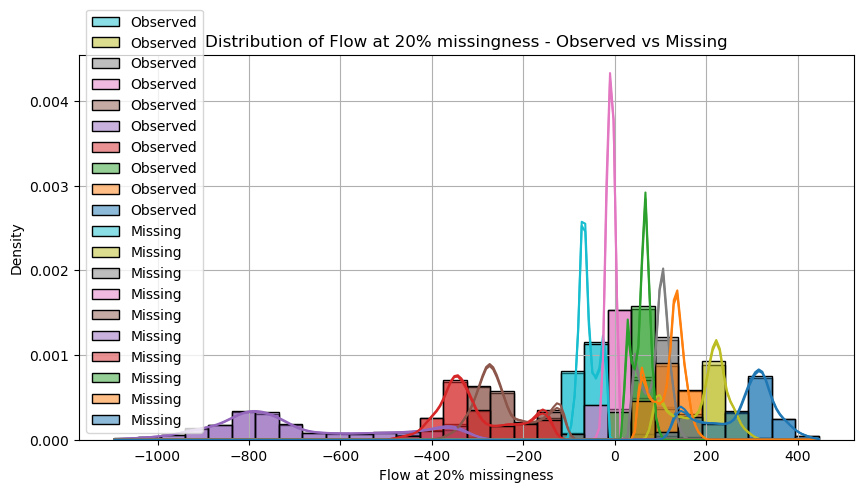

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_missing_vs_observed(data, mask, feature_name="flow"):
    """
    data: 1D array of original values
    mask: 1D boolean array, True if missing
    feature_name: for labeling
    """
    data_missing = data[mask]
    data_observed = data[~mask]

    plt.figure(figsize=(10, 5))
    sns.histplot(data_observed, color='blue', label='Observed', kde=True, stat="density", bins=30)
    sns.histplot(data_missing, color='red', label='Missing', kde=True, stat="density", bins=30)
    plt.title(f"Distribution of {feature_name} - Observed vs Missing")
    plt.xlabel(feature_name)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_missing_vs_observed(X_val_full_unscaled[0], val_masks[0][90], feature_name="Flow at 20% missingness")

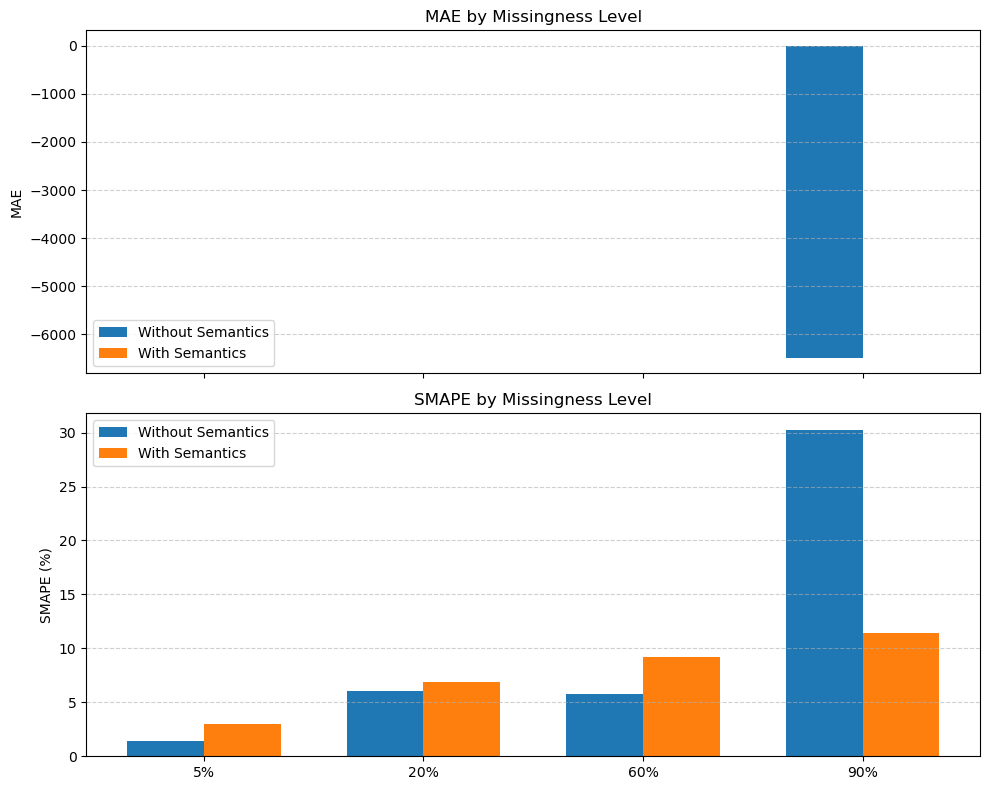

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Example error values (replace with your real variables)
missing_levels = ['5%', '20%', '60%', '90%']

# Bar chart setup
x = np.arange(len(missing_levels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- MAE plot ---
ax[0].bar(x - width/2, r2_all.values(), width, label='Without Semantics', color='tab:blue')
ax[0].bar(x + width/2, avg_r2_cluster.values(), width, label='With Semantics', color='tab:orange')
ax[0].set_ylabel('MAE')
ax[0].set_title('MAE by Missingness Level')
ax[0].legend()
ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)

# --- SMAPE plot ---
ax[1].bar(x - width/2, smape_all.values(), width, label='Without Semantics', color='tab:blue')
ax[1].bar(x + width/2, avg_smape_cluster.values(), width, label='With Semantics', color='tab:orange')
ax[1].set_ylabel('SMAPE (%)')
ax[1].set_title('SMAPE by Missingness Level')
ax[1].set_xticks(x)
ax[1].set_xticklabels(missing_levels)
ax[1].legend()
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

fig.tight_layout()
plt.show()
